In [ ]:
# referred github repo of Rehan Ahmad https://github.com/Rehan-Ahmad/Dictionary-Learning-Algorithms

In [61]:
import cv2
import numpy as np
from numpy.linalg import svd
import glob,os,time,pdb,warnings
from scipy.sparse.linalg import svds
from sklearn import preprocessing
from copy import deepcopy
import matplotlib.pyplot as plt
import joblib
warnings.filterwarnings('ignore')

In [3]:
path = '../dataset/'
X_files, y_class=[], []
class_number = 0
for dire in glob.glob(os.path.join(path, '*')):
    print(dire)
    for filename in glob.glob(os.path.join(dire, '*')):
        if('.info' in filename):
            continue
        st=filename.split('\\')
        s=st[0]+'/'+st[1]+'/'+st[2]
        X_files.append(s)
#         y_class.append(dire)
        y_class.append(class_number)
    class_number +=1
print(len(X_files),len(y_class))

../dataset\yaleB11
../dataset\yaleB12
../dataset\yaleB13
../dataset\yaleB15
../dataset\yaleB16
../dataset\yaleB17
../dataset\yaleB18
../dataset\yaleB19
../dataset\yaleB20
../dataset\yaleB21
5850 5850


In [12]:
X_data = []
for name in X_files:
    img=cv2.imread(r''+name,cv2.COLOR_BGR2GRAY) #converting to gray scale img
    img_resized = cv2.resize(img,(60,60),interpolation = cv2.INTER_AREA)
    X_data.append(img_resized)

X_ravel = []
for i in X_data:
    ravel = i.ravel()
    X_ravel.append(ravel)

X_ravel = np.asarray(X_ravel)

In [13]:
X_data[0].shape, X_ravel.shape

((60, 60), (5850, 3600))

### functions used

In [6]:
def plotShow(xLabel,yLabel,title):
    plt.legend()
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)
    plt.show()

### OMP (Orthogonal matching pursuit)
def omp(D,X,L): #dict, data, sparsity
    n,P = X.shape
    n,K = D.shape
    A = np.ndarray((D.shape[1],X.shape[1]))
    for k in range(P):
        a = 0
        x = deepcopy(X[:,k])
        residual = deepcopy(x)
        indx = np.zeros((L,),dtype = int)
        for j in range(L):
            proj = np.dot(D.T,residual)
            pos = np.argmax(np.abs(proj))
            indx[j] = int(pos)
            a = np.dot(np.linalg.pinv(D[:,indx[0:j+1]]),x)
            residual = x-np.dot(D[:,indx[0:j+1]],a)
            if np.sum(residual**2) < 1e-6:
                break
        temp = np.zeros((K,))
        temp[indx[0:j+1]] = deepcopy(a)
        A[:,k] = temp
    return A

### KSVD (like in lecture slide)
def KSVD(Data, Dictionary, CoefMat):
    Dict = deepcopy(Dictionary)        
    CoefMatrix = deepcopy(CoefMat)    
    rPerm = np.random.permutation(Dict.shape[1])
    for j in rPerm: 
        relevantDataIndices = np.nonzero(CoefMatrix[j,:])[0]
        if (len(relevantDataIndices)<1):
            ErrorMat = Data-np.dot(Dict,CoefMatrix)
            ErrorNormVec = np.sum(ErrorMat**2, axis = 0)
            d,i = np.max(ErrorNormVec),np.argmax(ErrorNormVec)
            betterDictionaryElement = deepcopy(Data[:,i])
            betterDictionaryElement = betterDictionaryElement/np.sqrt(\
                np.dot(betterDictionaryElement.T,betterDictionaryElement))
            betterDictionaryElement = betterDictionaryElement*\
                np.sign(betterDictionaryElement[0])
            CoefMatrix[j,:] = np.zeros((CoefMatrix.shape[1],))
            Dict[:,j] = deepcopy(np.reshape(betterDictionaryElement,(-1,)))            
            return Dict,CoefMatrix
    
        tmpCoefMatrix = deepcopy(CoefMatrix[:,relevantDataIndices]) 
        tmpCoefMatrix[j,:] = np.zeros((tmpCoefMatrix.shape[1]))
        errors = Data[:,relevantDataIndices] - np.dot(Dict,tmpCoefMatrix) 
        try:
            uu,ss,vv = svd(errors)
            betterDictionaryElement,singularValue,betaVector = uu[:,0],ss[0],vv[0,:]
        except: 
            print("Error has occured in svd...You are now in pdb mode")
            pdb.set_trace()
                
        CoefMatrix[j,relevantDataIndices] = np.dot(singularValue,betaVector)
        Dict[:,j] = deepcopy(np.reshape(betterDictionaryElement,(-1,)))
        
    return Dict, CoefMatrix

### FindDistanceBetweenDictionaries
def FindDistanceBetweenDictionaries(D,Dhat):
    catchCounter = 0 
    totalDistances = 0
    Dnew = np.ndarray((D.shape[0],D.shape[1]))
    for i in range(Dhat.shape[1]):
        Dnew[:,i] = deepcopy(np.sign(Dhat[0,i])*Dhat[:,i])
    for i in range(Dhat.shape[1]):
        d = deepcopy(np.sign(D[0,i])*D[:,i])
        distances = np.sum((Dnew-np.tile(np.reshape(d,(-1,1)),(1,Dhat.shape[1])))**2,axis=0)
        index = np.argmin(distances)
        errorOfElement = 1 - np.abs(np.dot(Dnew[:,index],d))
        totalDistances = totalDistances + errorOfElement
        catchCounter = catchCounter + (errorOfElement < 0.01)
    return catchCounter

In [14]:
X_ravel.shape

(5850, 3600)

In [19]:
Y = deepcopy(X_ravel)

In [22]:
drows, dcols, ycols = 5850, 100, 3600
alpha = 0.005
epochs, iterations = 2, 10
sparsity = 4

count_success_KSVD = np.ndarray((iterations, epochs))
e_KSVD = np.ndarray((iterations, epochs))

In [23]:
tic = time.time()
for epoch in range(epochs):
    alpha = 0.005
    # Creating dictionary from uniform iid random distribution and normalizing atoms by l2-norm
    D = np.random.rand(drows, dcols)
    D = preprocessing.normalize(D, norm='l2', axis=0)

    Dhat = np.ndarray((drows, dcols))
    Dhat = deepcopy(Y[:, np.random.permutation(ycols)[0:dcols]])
    Dhat = preprocessing.normalize(Dhat, norm='l2', axis=0)
    Dhat_KSVD = deepcopy(Dhat)
    X = omp(D, Y, sparsity)

    for j in range(iterations):
        #            X = omp(Dhat_KSVD,Y,sparsity)
        Dhat_KSVD, X = KSVD(Y, Dhat_KSVD, X)
        count_KSVD = FindDistanceBetweenDictionaries(D, Dhat_KSVD)
        count_success_KSVD[j, epoch] = count_KSVD
        e_KSVD[j, epoch] = np.linalg.norm(Y - np.dot(Dhat_KSVD, X), 'fro') ** 2
        print(j)
    break
toc = time.time()

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


No handles with labels found to put in legend.


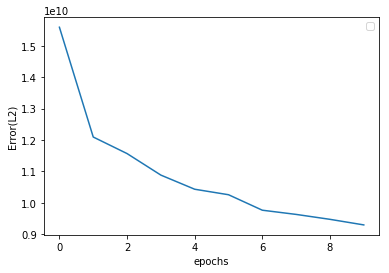

Execution time:  68.77 min


In [25]:
plt.plot(np.sum(e_KSVD, axis=1) / epochs)
plotShow('epochs', 'Error(L2)', '')
print('Execution time: ', '%.2f' % ((toc - tic) / 60.0), 'min')

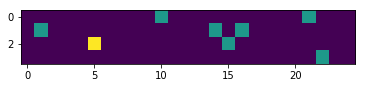

In [18]:
plt.imshow(Dhat_KSVD[0,:].reshape(4,25))

In [35]:
result = np.matmul(Dhat_KSVD,X)
result.shape

(5850, 3600)

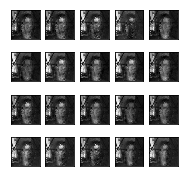

In [54]:
fig=plt.figure(figsize=(3,3))

for idx in np.arange(20):
    ax=fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(result[idx].reshape(60,60)),cmap='gray')

In [57]:
# result = np.matmul(Dhat_KSVD,X)
# result.shape

# for i in range(5):
#     plt.imshow(result[i,:].reshape(60,60))
#     plt.show()

In [62]:
model = joblib.load('./subhani.joblib')

In [64]:
graph = model[0]
dictionary = model[1]
graph.shape, dictionary.shape

((50,), torch.Size([585, 784]))

No handles with labels found to put in legend.


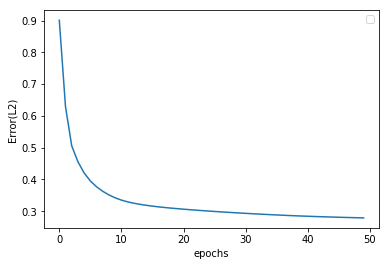

In [68]:
plt.plot(graph)
plotShow('epochs', 'Error(L2)', '')

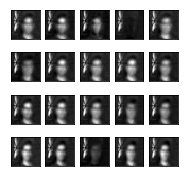

In [73]:
fig=plt.figure(figsize=(3,3))
dictionary = dictionary.cpu()
for idx in np.arange(20):
    ax=fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(dictionary[idx].reshape(28,28)),cmap='gray')